# Signal to Binary Files (Train&Test)

In this notebook we read the Basic 4 dataset through Spark, and convert signals into a binary file.

In [1]:
import requests
import json
#!pip install ibmseti
import ibmseti
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import os
from PIL import Image
#!pip install pandas
#import pandas as pd   

In [2]:
import findspark
findspark.init()
import pyspark
import random
sc = pyspark.SparkContext(appName="seti")

In [3]:
### SET YOUR TEAM NAME HERE! Use this folder to save intermediate results
team_name = 
mydatafolder = os.path.join( os.environ['PWD'], team_name )  #Change my_data_folder to your team name
if os.path.exists(mydatafolder) is False:
    os.makedirs(mydatafolder)
    
## REMEMBER, on Nimbix, your local file space is destroyed when your cloud machine is shut down. So be sure to commit/save your work!

basicIndex = '/data/seti/simsignals_files/public_list_basic_v2_26may_2017.csv' 
basicSetiDataDir = '/data/seti/simsignals_basic_v2'

workingDataDir = basicSetiDataDir

### Get file list

I have a list of simulated files stored in an OpenStack Object Storage container that is world-readable.

Download that file, split by lines and parallelize it into an RDD

In [4]:
def get_filename_lb(row):  
    try:
        uuid, class_lb = row.split(',')
    except:
        uuid = row #this handles the test data since it doesn't have "SIGNAL_CLASSIFICATION" in index file
        class_lb = 'unknown'
    return [class_lb,uuid]

In [5]:
# we parallelize the index file across our worker executors
filename_rdd = sc.textFile(basicIndex).filter(lambda x: x.startswith('UUID') is False).map(lambda row: get_filename_lb(row)) #the filter removes the header
filename_rdd.first()

[u'narrowband', u'b1cc342f-eae4-442b-91de-10c9a444072e']

### Get the class label dictionary

In [6]:
rdd_fname_lb = filename_rdd.map(lambda row: (row[0],row[1]))
classes = rdd_fname_lb.map(lambda row: row[0]).distinct().collect()
dictClass = dict(zip(classes, np.arange(4)))
dictClass

{u'narrowband': 0, u'narrowbanddrd': 2, u'noise': 3, u'squiggle': 1}

# Open data, and convert signals to spectogram

In [7]:
def get_spectrogram(uuid,h,w,lengthRatio=1.0):
    
    #create path to local data file
    filename = uuid + '.dat'
    filepath = os.path.join(workingDataDir, filename)
    
    #retrieve that data file
    rawdata = open(filepath).read()
    
    
    aca = ibmseti.compamp.SimCompamp(rawdata)
    com_data = aca.complex_data()
    ratio = int(np.sqrt(len(com_data) *lengthRatio / (h*w)))
    if ratio == 0: 
        raise ValueError, "The selected lenght of signal is less than (Height x Width), select bigger ratio"
    elif ratio == 1:
        sig_data = com_data[:h*w].reshape(h,w)
        spec = np.abs( np.fft.fftshift( np.fft.fft(sig_data), 1) )**2
        spec = np.log(spec) # Convert to float (0-255)
        image = 255*(spec/np.max(spec)) 
    elif ratio > 1: # resize using IPL image
        sig_data = com_data[:h*ratio*w*ratio].reshape(h*ratio,w*ratio)
        spec = np.abs( np.fft.fftshift( np.fft.fft(sig_data), 1) )**2
        spec = np.log(spec) # Convert to float (0-255)
        image = 255*(spec/np.max(spec)) 
        img = Image.fromarray(image)  
        img = img.resize((int(w), int(h)), Image.ANTIALIAS)
        image = np.asarray(img) # float (0-255)
        
                
        # convert to grayscale: int(0-255)
        image = np.uint8(image)
        
        return image

h and w are the hight and width of the images, and lengthRatio is the length of signal in ratio.

In [8]:
h = 64 # The hight of output image (bins)
w = 128 # The witdh of output image
lengthRatio = 1.0  # the length-ration of signal to be read. The higher reatio, the better resolution. E.g. 0.5 means half of time sereis.
rdd_gray_spec = filename_rdd.map(lambda row: (row[1], dictClass[row[0]],  get_spectrogram(row[1],h,w,lengthRatio)))

In [9]:
rdd_gray_spec.cache()

PythonRDD[8] at RDD at PythonRDD.scala:48

### verify

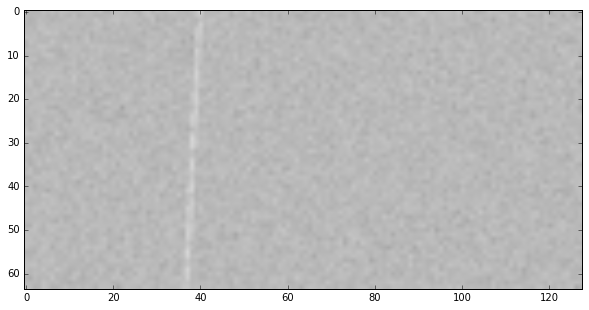

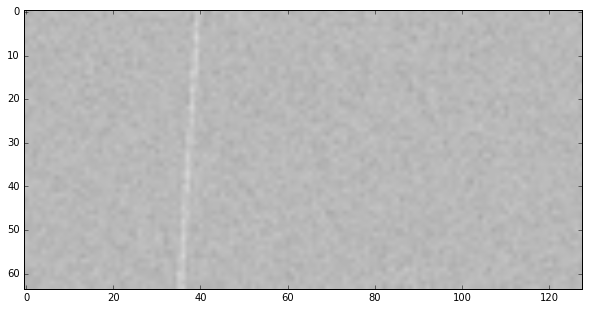

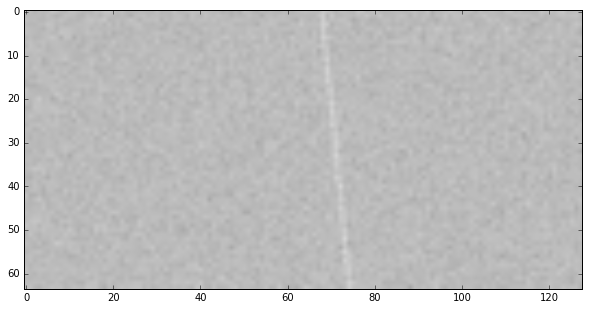

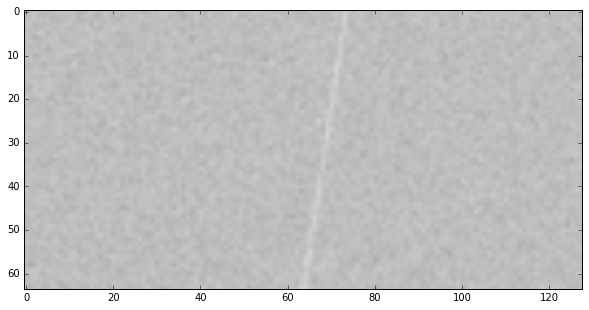

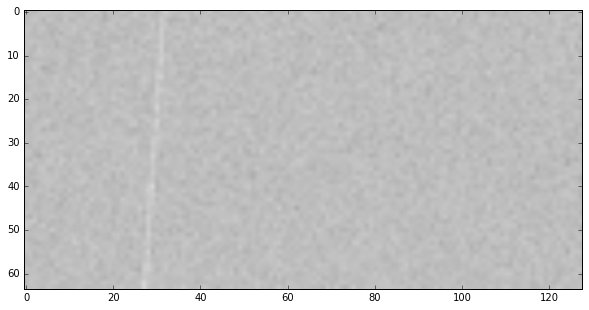

In [10]:
z=5
y= rdd_gray_spec.take(z)
for i in range(z):
    img = Image.fromarray(np.float32(y[i][2]))
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(img)

# Train/Test

In [11]:
test, train = rdd_gray_spec.randomSplit(weights=[0.3, 0.7], seed=1)

In [12]:
train_data = train.map(lambda row: row[2]).collect()
train_img_data = np.array(train_data)
train_lbl = train.map(lambda row: row[1]).collect()

In [13]:
test_data = test.map(lambda row: row[2]).collect()
test_img_data = np.array(test_data)
test_lbl = test.map(lambda row: row[1]).collect()

### Write to Binary file
This binary file is same as famouse __mnist__ dataset format to be read by different image processing algorithms, learning techniques and pattern recognition methods. 

There are 4 files:  

- train-images-idx3-ubyte: training set images 
- train-labels-idx1-ubyte: training set labels 
- test-images-idx3-ubyte:  test set images 
- test-labels-idx1-ubyte:  test set labels



In [14]:
from array import *
def wrtieToBinary(ds_directory, name , imgData , lblData,h,w):
    
    n = imgData.shape[0]
    imgData = imgData.reshape(-1,)
    
    data_image = array('B')
    data_label = array('B')
    
    data_image.extend(imgData)

    # number of files in HEX
    hexval = "{0:#0{1}x}".format(n,6) 
    
    # header for label array
    data_label.extend(lblData)
    header = array('B')
    header.extend([0,0,8,1,0,0])
    header.append(int('0x'+hexval[2:][:2],16))
    header.append(int('0x'+hexval[2:][2:],16))
    data_label = header + data_label
    print ('Label header:' )
    print(header)
    # additional header for images array
    if max([w,h]) <= 255:
        header.extend([0,0,0,h,0,0,0,w])
    else:
        hex_h = "{0:#0{1}x}".format(h,6)
        header.extend([0,0])
        header.append(int('0x'+hex_h[2:][:2],16))
        header.append(int('0x'+hex_h[2:][2:],16))
        hex_w = "{0:#0{1}x}".format(w,6)
        header.extend([0,0])
        header.append(int('0x'+hex_w[2:][:2],16))
        header.append(int('0x'+hex_w[2:][2:],16))
        #raise ValueError('Image exceeds maximum size: 256x256 pixels');
    header[3] = 3 # Changing MSB for image data (0x00000803)
        
    if not os.path.exists(ds_directory):
        os.makedirs(ds_directory)
            
        
    print ('Image header:' )
    print(header)
    data_image = header + data_image

    output_file = open(ds_directory + name+'-images-idx3-ubyte', 'wb')
    data_image.tofile(output_file)
    output_file.close()

    output_file = open(ds_directory+ name+'-labels-idx1-ubyte', 'wb')
    data_label.tofile(output_file)
    output_file.close()
    
    # gzip resulting files


    os.system('gzip '+ ds_directory + name +'-images-idx3-ubyte '+ name +'-images-idx3-ubyte.gz')
    os.system('gzip '+ ds_directory + name +'-labels-idx1-ubyte ')


In [15]:
ds_directory = 'SETI/SETI_ds_64x128/'  # The dataset directory to write the binary files
os.system('rm '+ds_directory+'*')
print os.popen("ls -lrt "+ ds_directory).read()

total 0



In [16]:
wrtieToBinary(ds_directory, 'train' , train_img_data , train_lbl, h, w)

Label header:
array('B', [0, 0, 8, 1, 0, 0, 11, 24])
Image header:
array('B', [0, 0, 8, 3, 0, 0, 11, 24, 0, 0, 0, 64, 0, 0, 0, 128])


In [17]:
wrtieToBinary(ds_directory, 'test' , test_img_data , test_lbl, h, w)

Label header:
array('B', [0, 0, 8, 1, 0, 0, 4, 136])
Image header:
array('B', [0, 0, 8, 3, 0, 0, 4, 136, 0, 0, 0, 64, 0, 0, 0, 128])


### Verify the binary files
Lets read the binary file and plot an image

In [18]:
print os.popen("ls -lrt "+ ds_directory).read()

total 19932
-rw-r--r-- 1 root root      128 Jun  8 17:26 train-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 14478078 Jun  8 17:26 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root      112 Jun  8 17:26 test-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root  5921189 Jun  8 17:26 test-images-idx3-ubyte.gz



In [19]:
import numpy as np
import gzip
def _read32(bytestream):
  dt = np.dtype(np.uint32).newbyteorder('>')
  return np.frombuffer(bytestream.read(4), dtype=dt)[0]

with open(ds_directory+'train-images-idx3-ubyte.gz', 'rb') as f:
    with gzip.GzipFile(fileobj=f ) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %(magic, f.name))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        print(magic,num_images,rows,cols,)
        
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
# magic, num, rows, cols = struct.unpack(">IIII", bytestream.read(16))


(2051, 2840, 64, 128)


F


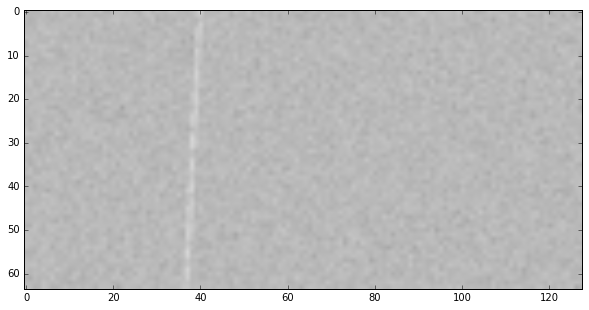

In [20]:
gray_y = data[0].reshape(h,w)
img = Image.fromarray(np.float32(gray_y))
print (img.mode)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(img)

In [21]:
gray_y

array([[184, 181, 180, ..., 184, 179, 184],
       [185, 181, 184, ..., 182, 174, 181],
       [183, 177, 181, ..., 189, 184, 189],
       ..., 
       [181, 172, 187, ..., 181, 181, 184],
       [185, 185, 184, ..., 189, 190, 187],
       [191, 188, 177, ..., 193, 170, 178]], dtype=uint8)

### Verify the binary files by reader class
__SETI.py__ is a helper class, identical to mnist dataset reader, to easily read dataset, one-hot coding, and read images as batch.

In [22]:
!wget -q --output-document SETI.zip  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
!unzip -o SETI.zip
import SETI

Archive:  SETI.zip
  inflating: SETI.py                 
  inflating: __MACOSX/._SETI.py      


In [23]:
SETIds = SETI.read_data_sets(ds_directory, one_hot=True, validation_size=0)
SETIds.train.num_examples

Extracting SETI/SETI_ds_64x128/train-images-idx3-ubyte.gz
Extracting SETI/SETI_ds_64x128/train-labels-idx1-ubyte.gz
Extracting SETI/SETI_ds_64x128/test-images-idx3-ubyte.gz
Extracting SETI/SETI_ds_64x128/test-labels-idx1-ubyte.gz


2840

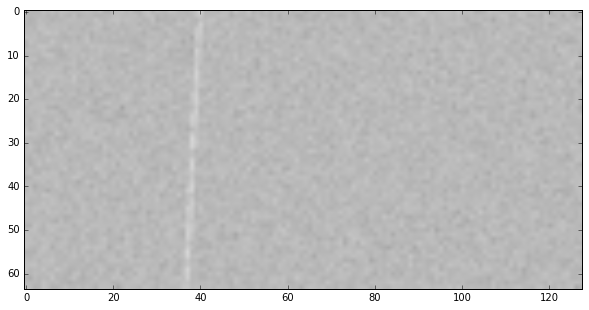

In [24]:
gray_y = SETIds.train.images[0].reshape(h,w)
img = Image.fromarray(gray_y*255)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(img)

In [ ]:
# old    
#  
# primarySmallIndex = '/data/seti/simsignals_files/public_list_primary_v2_small_1june_2017.csv' 
# primaryMediumIndex = '/data/seti/simsignals_files/public_list_primary_v2_medium_1june_2017.csv'
#testSetIndex =  '/data/seti/simsignals_files/public_list_primary_testset_mini_1june_2017.csv'
#primarySetiDataDir = '/data/seti/simsignals_v2'  #THIS ONLY CONTAINS THE SMALL AND MEDIUM DATA FILES!  
# Ask Adam, Patrick or Joseph on Saturday evening if you want the full data set. Hint: It's in simsignals_v2_full_N, for N=1,2,3,4 


